In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.base import TransformerMixin
from sklearn.learning_curve import learning_curve

from sklearn.externals import joblib

In [2]:
def clean_data(data,
               remove_anormal=True,
               useless_columns=["AGENCIA_NMBAIRRO", "NRENDERE", "QTFUNCIO", "DSSEXO", 
                                "DSPROFTL", "NMBAIRRO", "AGENCIA_DSENDCOP", "DSENDERE", 
                                "AGENCIA_NMRESAGE", "AGENCIA_NMCIDADE"],
               remove_redundant=True,
               remove_product_value=True,
               dummify_categorical=True,
               booleanfy=True
              ):

    count_vector = {}
    for column in data.columns.values:
        count_vector[column] = Counter(data[column])
    
    # Colunas com apenas 1 tipo de dado
    redundant_columns = []

    # Colunas que representam o valor de um produto
    product_value_columns = []

    # Colunas que devem ser dummified
    dummy_columns = []

    # Para cada coluna no count_vector
    for k, v in count_vector.items():

        # ignora colunas inúteis    
        if k in useless_columns:
            continue
        # Encontra redundantes    
        elif len(v) == 1 and remove_redundant:
            redundant_columns.append(k)
        # Encontra colunas de valores de produto    
        elif k.startswith("VL") and remove_product_value:
            product_value_columns.append(k)
        # dummify    
        elif len(v) > 2 and (not k.startswith("VL") and not k.startswith("QTDE")) and dummify_categorical:
            dummy_columns.append(k)
        #  booleanfy boolean columns (1 == most common)   
        elif len(v) == 2 and booleanfy:
            if not (v.most_common()[0][0] == 0 or v.most_common()[0][0] == 1) or not (v.most_common()[1][0] == 0 or v.most_common()[1][0] == 1):
                data[k] = data[k].map({v.most_common()[0][0]: 1, v.most_common()[1][0]: 0})


    # Remove as colunas indicadas
    data = data.drop(redundant_columns, axis=1)
    
    data = data.drop(product_value_columns, axis=1)

    data = data.drop(useless_columns, axis=1)
    
    data = pd.get_dummies(data, columns=dummy_columns)
    
    return data

def select_product(data, product_name, produtos, include_other_products=False):
    produtos = produtos
    produto = data[product_name]
    if include_other_products:
        data = data.drop(product_name, axis=1)
    else:
        data = data.drop(produtos, axis=1)
    return data, produto

# Helper pra criar test e train set pra um produto
def train_test_sets(df, product, produtos, test_size=0.2, include_other_products=False):
    data, p = select_product(df, product, produtos, include_other_products)
    return train_test_split(data, p, test_size=test_size)


def get_sets(data, product_name, produtos, test_size=0.2, include_other_products=False):
    return train_test_sets(data, product_name, produtos, test_size, include_other_products)


def train_model(data_train, label_train, pipeline):
    pipeline.fit(data_train, label_train)
    return pipeline



def confusion_test(data_test, label_test, fitted_pipeline):
    predicted = fitted_pipeline.predict(data_test)
    
    print()
    print("Train set size:", len(data_train), "Test set size:", len(data_test))
    print(classification_report(label_test, predicted))
    plt.matshow(confusion_matrix(predicted, label_test), cmap=plt.cm.binary, interpolation='nearest')
    plt.colorbar()
    plt.ylabel('expected label')
    plt.xlabel('predicted label')
    plt.show()
    return

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=10, train_sizes=np.linspace(.1, 1.0, 5)):
    print("Creating figure")
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    print("Creating learning curve")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    print("Processing results")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print("Creating grid")
    plt.grid()
    print("Filling grid")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    print("Plotting")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def product_learning_curves(data, product, produtos, title, pipeline, include_other_products=False, cv=10):
    data_vector, label_vector = select_product(data, product, produtos, include_other_products=False)
    %time plot_learning_curve(pipeline, "accuracy vs. training set size ({})".format(title), data_vector, label_vector, cv=cv)


def save_model(model, file):
    joblib.dump(model, file)

def load_model(file):
    return joblib.load(file)

In [3]:
# Constants
produto = 0

In [4]:
# Get data
df = pd.read_csv("data/data.csv", sep="|", low_memory=False)

In [5]:
# Clean it
clean_kwargs = {
    "useless_columns": ["AGENCIA_NMBAIRRO", "NRENDERE", "QTFUNCIO", "DSSEXO", 
                        "DSPROFTL", "NMBAIRRO", "AGENCIA_DSENDCOP", "DSENDERE", 
                        "AGENCIA_NMRESAGE", "AGENCIA_NMCIDADE"],
    "remove_redundant": True,
    "remove_product_value": True,
    "dummify_categorical": True,
    "booleanfy": True,
}
df = clean_data(df, **clean_kwargs)

In [6]:
# Get product list
produtos = list(filter(lambda x: x.startswith("QTDE"), df.columns.values))

In [7]:
# get sets
sets_kwargs = {
    "include_other_products": False,
    "test_size": 0.2
}
data_train, data_test, label_train, label_test = get_sets(df, produtos[produto], produtos, **sets_kwargs)

In [8]:
pipeline = Pipeline([
    ('classifier', MultinomialNB()),
])

In [9]:
# Train model
trained_pipeline = train_model(data_train, label_train, pipeline)
save_model(trained_pipeline, "model.pkl")


Train set size: 49421 Test set size: 12356
             precision    recall  f1-score   support

          0       0.95      0.91      0.93      1938
          1       0.98      0.99      0.99     10418

avg / total       0.98      0.98      0.98     12356



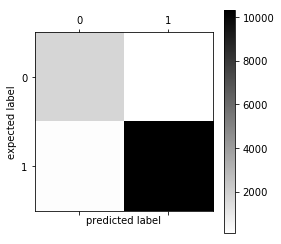

In [10]:
# Plot confusion matrix
confusion_test(data_test, label_test, trained_pipeline)

Creating figure
Creating learning curve
Processing results
Creating grid
Filling grid
Plotting
CPU times: user 51.4 s, sys: 29.9 s, total: 1min 21s
Wall time: 57 s


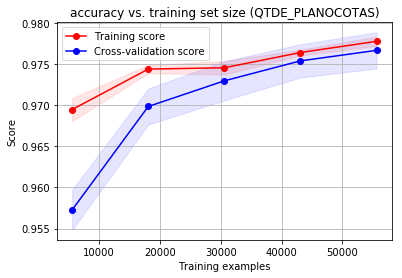

In [11]:
# Plot learning curve
learning_kwargs = {
    "include_other_products": False,
    "cv": 10,
}
product_learning_curves(df, produtos[produto], produtos, produtos[produto], pipeline, **learning_kwargs)

In [12]:
# Load trained model
model = load_model("model.pkl")
# Make a prediction
results = list(map(lambda x: x[0], model.predict_proba(data_test)))
results.sort(reverse=True)
print(results)

[0.99999999992971311, 0.99999999982608756, 0.99999999964789765, 0.99999999956750685, 0.99999999927618433, 0.99999999904711956, 0.99999999897305258, 0.99999999795831229, 0.99999999791853611, 0.99999999717203991, 0.99999999712380827, 0.99999999708518317, 0.99999999700716558, 0.99999999649118365, 0.99999999647361903, 0.99999999645713444, 0.99999999618445656, 0.99999999592526478, 0.99999999588007427, 0.99999999586501076, 0.99999999573691412, 0.99999999570701448, 0.99999999540568751, 0.99999999526360739, 0.99999999498673731, 0.99999999481231328, 0.99999999428099784, 0.99999999408549911, 0.99999999353227054, 0.99999999329610034, 0.99999999291171093, 0.99999999274464813, 0.99999999150367103, 0.99999999141772378, 0.9999999914121247, 0.99999999109816429, 0.99999999083649982, 0.99999999072250034, 0.99999999051449606, 0.99999998963728842, 0.99999998963728842, 0.99999998963728842, 0.9999999890665664, 0.99999998871058449, 0.99999998859313177, 0.99999998823437874, 0.99999998750223551, 0.999999986975